In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bossbase/boss_256_0.4/cover/4353.png
/kaggle/input/bossbase/boss_256_0.4/cover/7968.png
/kaggle/input/bossbase/boss_256_0.4/cover/6490.png
/kaggle/input/bossbase/boss_256_0.4/cover/5511.png
/kaggle/input/bossbase/boss_256_0.4/cover/6262.png
/kaggle/input/bossbase/boss_256_0.4/cover/2664.png
/kaggle/input/bossbase/boss_256_0.4/cover/8419.png
/kaggle/input/bossbase/boss_256_0.4/cover/2539.png
/kaggle/input/bossbase/boss_256_0.4/cover/5703.png
/kaggle/input/bossbase/boss_256_0.4/cover/1231.png
/kaggle/input/bossbase/boss_256_0.4/cover/1017.png
/kaggle/input/bossbase/boss_256_0.4/cover/4803.png
/kaggle/input/bossbase/boss_256_0.4/cover/7197.png
/kaggle/input/bossbase/boss_256_0.4/cover/2437.png
/kaggle/input/bossbase/boss_256_0.4/cover/7530.png
/kaggle/input/bossbase/boss_256_0.4/cover/3217.png
/kaggle/input/bossbase/boss_256_0.4/cover/5695.png
/kaggle/input/bossbase/boss_256_0.4/cover/8565.png
/kaggle/input/bossbase/boss_256_0.4/cover/6441.png
/kaggle/input/bossbase/boss_256

In [3]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import List

In [4]:
img_path = "/kaggle/input/bossbase/boss_256_0.4/cover/100.png"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape: (512, 512)

In [5]:
#SRM Filter

#(3×3 kernels)
srm_filters = [
    np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),  # horizontal diff
    np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),  # vertical diff
    np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]])  # laplacian-like
]

In [6]:
#Gabor Filter

def gabor_kernels(ksize=11):
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):  # 0,45,90,135 degrees
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kernels.append(kern.astype(np.float32))
    return kernels

gabor_kerns = gabor_kernels()

In [7]:
class BossBaseDataset(Dataset):
    def __init__(self, cover_dir, stego_dir=None, transform=None):

        self.cover_files = sorted([
            os.path.join(cover_dir, f) for f in os.listdir(cover_dir) if f.lower().endswith(".png")
        ])
        self.stego_files = sorted([
            os.path.join(stego_dir, f) for f in os.listdir(stego_dir) if stego_dir and f.lower().endswith(".png")
        ]) if stego_dir else []

        self.transform = transform

        self.srm_filters = [
            np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]], dtype=np.float32),
            np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]], dtype=np.float32),
            np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]], dtype=np.float32)
        ]
        self.gabor_kerns = gabor_kernels(ksize=11)

        self.num_channels = len(self.srm_filters) + len(self.gabor_kerns) + 1

    def __len__(self):
        return len(self.cover_files) + len(self.stego_files)

    def _apply_filters(self, img):
        img_f = img.astype(np.float32)
        residuals = [cv2.filter2D(img_f, -1, k) for k in self.srm_filters]    # list of (H,W)
        gabors   = [cv2.filter2D(img_f, -1, k) for k in self.gabor_kerns]     # list of (H,W)
        residual_maps = np.stack(residuals, axis=2)   # (H, W, Cr)
        gabor_maps    = np.stack(gabors, axis=2)     # (H, W, Cg)
        return residual_maps, gabor_maps

    def __getitem__(self, idx):
        if idx < len(self.cover_files):
            img_path = self.cover_files[idx]
            label = 0.0  # cover
        else:
            img_path = self.stego_files[idx - len(self.cover_files)]
            label = 1.0  # stego

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape (H, W)
        if img is None:
            raise FileNotFoundError(f"Cannot load image: {img_path}")

        residual_maps, gabor_maps = self._apply_filters(img)

        gray_ch = img.astype(np.float32)[..., None]            # (H, W, 1)

        combined = np.concatenate([residual_maps, gabor_maps, gray_ch], axis=2)

        combined = combined.transpose(2, 0, 1).astype(np.float32)

        combined = combined / 255.0

        tensor = torch.from_numpy(combined)  # (C, H, W)

        if self.transform:
            tensor = self.transform(tensor)

        return tensor, torch.tensor(label, dtype=torch.float32)

In [8]:
class ResidualAttentionBlock(nn.Module):
    """Block: global pooling -> 1x1 conv (reduce) -> ReLU -> 1x1 conv (expand) -> Sigmoid -> channel reweight -> 1x1 conv -> GroupNorm -> ReLU -> add residual"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # (B,C,1,1)
        self.gate = nn.Sequential(
            nn.Conv2d(channels, reduced, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
        self.out_conv = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, channels), num_channels=channels)

        self.last_weights = None   #to store the attention weights

    def forward(self, x):
        s = self.global_pool(x)        # (B, C, 1, 1)
        s = self.gate(s)               # (B, C, 1, 1)
        if not self.training:          # remove this to print the ran arch for each run
            print("Channel weights:", s.view(s.size(0), -1).detach().cpu().numpy())
        self.last_weights = s.detach().cpu().numpy()
        x_scaled = x * s             
        out = self.out_conv(x_scaled)
        out = self.norm(out)
        out = F.relu(out, inplace=True)
        return out + x              

In [9]:
class ConvBlockPool(nn.Module):
    """Conv -> ReLU -> MaxPool(2) with residual (skip downsampled)"""
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        if in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch),
                nn.AvgPool2d(kernel_size=2, stride=2)
            )
        else:
            self.skip = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        y = self.conv(x)
        y = self.norm(y)
        y = F.relu(y, inplace=True)
        y = self.pool(y)
        s = self.skip(x)
        return F.relu(y + s, inplace=True)


In [10]:
class ConvBlockGlobalPool(nn.Module):
    """Conv -> ReLU -> AdaptiveAvgPool2d(1) -> small gating -> channel-wise scaling -> residual add"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.norm = nn.GroupNorm(num_groups=min(8, channels), num_channels=channels)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.ch_gate = nn.Sequential(
            nn.Conv2d(channels, reduced, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.conv(x)
        y = self.norm(y)
        y = F.relu(y, inplace=True)
        p = self.pool(y)         # (B, C, 1, 1)
        g = self.ch_gate(p)      # (B, C, 1, 1)
        y2 = y * g               # gated
        return F.relu(y2 + x, inplace=True)

In [11]:
class ResidualAttentionNet(nn.Module):
    """
    Outputs a feature map (B, C_latent, H_out, W_out)
    """
    def __init__(self, c_in, base_ch=32):
        super().__init__()
        self.init_conv = nn.Conv2d(c_in, base_ch, kernel_size=3, padding=1, bias=False)
        self.init_norm = nn.GroupNorm(num_groups=min(8, base_ch), num_channels=base_ch)

        self.att1 = ResidualAttentionBlock(base_ch, reduction=8)
        self.convpool = ConvBlockPool(base_ch, base_ch * 2)
        self.att2 = ResidualAttentionBlock(base_ch * 2, reduction=8)
        self.globalblock = ConvBlockGlobalPool(base_ch * 2, reduction=8)

        self.project = nn.Conv2d(base_ch * 2, base_ch * 4, kernel_size=1, bias=False)
        self.project_norm = nn.GroupNorm(num_groups=min(8, base_ch * 4), num_channels=base_ch * 4)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.init_norm(x)
        x = F.relu(x, inplace=True)

        x = self.att1(x)        # (B, base_ch, H, W)
        x = self.convpool(x)    # (B, base_ch*2, H/2, W/2)
        x = self.att2(x)        # (B, base_ch*2, H/2, W/2)
        x = self.globalblock(x) # (B, base_ch*2, H/2, W/2)

        x = self.project(x)
        x = self.project_norm(x)
        x = F.relu(x, inplace=True)
        return x

In [12]:
cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover"
stego_dir = "/kaggle/input/bossbase/boss_256_0.4/stego"

dataset = BossBaseDataset(cover_dir, stego_dir)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

c_in = dataset.num_channels

# init RAN with that channel count
ran = ResidualAttentionNet(c_in, base_ch=32) #change this base channel value accordingly

#print(ran)  # print the model repr as you did earlier

# get batches and run through RAN
for batch in dataloader:
    fused_input, labels = batch  # fused_input: (B, C, H, W)
    print("Fused input shape:", fused_input.shape)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ran = ran.to(device)
    fused_input = fused_input.to(device)

    attended_features = ran(fused_input)
    print("Attended features:", attended_features.shape)
    break

Fused input shape: torch.Size([4, 8, 256, 256])
Attended features: torch.Size([4, 128, 128, 128])


In [13]:
class TinyRAN(nn.Module):
    def __init__(self, c_in=1, base_ch=32):
        super().__init__()
        self.init_conv = nn.Conv2d(c_in, base_ch, 3, padding=1, bias=False)
        self.init_norm = nn.GroupNorm(num_groups=min(8, base_ch), num_channels=base_ch)
        self.att1 = ResidualAttentionBlock(base_ch, reduction=8)

    def forward(self, x):
        x = F.relu(self.init_norm(self.init_conv(x)))
        x = self.att1(x)
        return x

In [14]:
def visualize_attention_weights(model, cover_img, stego_img):
    with torch.no_grad():
        _ = model(cover_img.unsqueeze(0).unsqueeze(0))  # add batch+channel dims
        cover_w = model.att1.last_weights.squeeze()     # shape (C,)
        
        _ = model(stego_img.unsqueeze(0).unsqueeze(0))
        stego_w = model.att1.last_weights.squeeze()

    plt.figure(figsize=(12,5))
    idx = np.arange(len(cover_w))
    plt.bar(idx - 0.2, cover_w, width=0.4, label="Cover")
    plt.bar(idx + 0.2, stego_w, width=0.4, label="Stego")
    plt.xlabel("Channel index")
    plt.ylabel("Attention weight")
    plt.title("RAN Attention Weights: Cover vs Stego")
    plt.legend()
    plt.show()

In [15]:
class TinyRANClassifier(nn.Module):
    def __init__(self, c_in=1, base_ch=32, num_classes=2):
        super().__init__()
        self.init_conv = nn.Conv2d(c_in, base_ch, 3, padding=1, bias=False)
        self.init_norm = nn.GroupNorm(num_groups=min(8, base_ch), num_channels=base_ch)
        self.att1 = ResidualAttentionBlock(base_ch, reduction=8)

        # simple classifier head
        self.pool = nn.AdaptiveAvgPool2d(1)   # (B, C, 1, 1)
        self.fc = nn.Linear(base_ch, num_classes)

    def forward(self, x):
        x = F.relu(self.init_norm(self.init_conv(x)))
        x = self.att1(x)              # (B, C, H, W)
        x = self.pool(x).squeeze(-1).squeeze(-1)  # (B, C)
        logits = self.fc(x)           # (B, num_classes)
        return logits


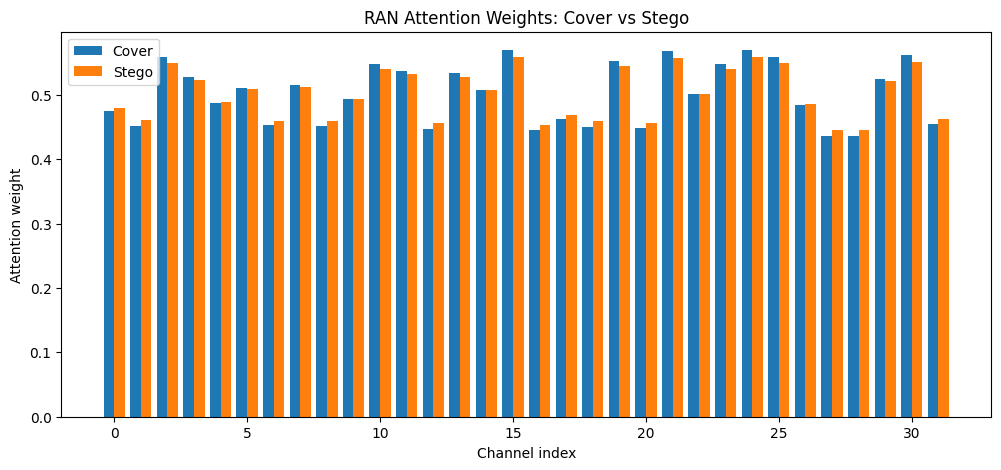

In [16]:
cover_dir = "/kaggle/input/bossbase/boss_256_0.4/cover/1.png"
stego_dir = "/kaggle/input/bossbase/boss_256_0.4/stego/1.png"

cover_img = cv2.imread(cover_dir, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
stego_img = cv2.imread(stego_dir, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

cover_img = torch.rand(64, 64)  # 64x64 grayscale
stego_img = cover_img.clone() + 6.5 * torch.randn_like(cover_img)
stego_img = stego_img.clamp(0, 1)  # keep pixels in valid range
    
model = TinyRAN(c_in=1, base_ch=32)


visualize_attention_weights(model, cover_img, stego_img)

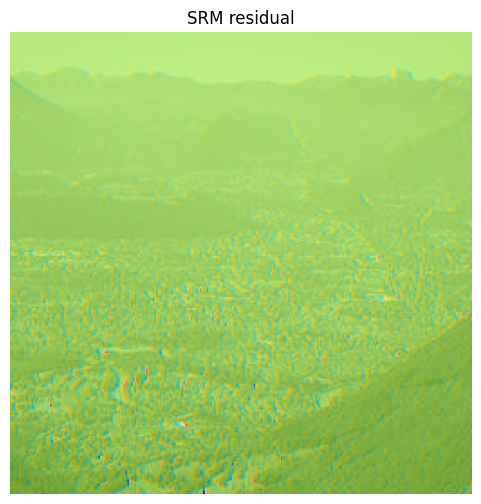

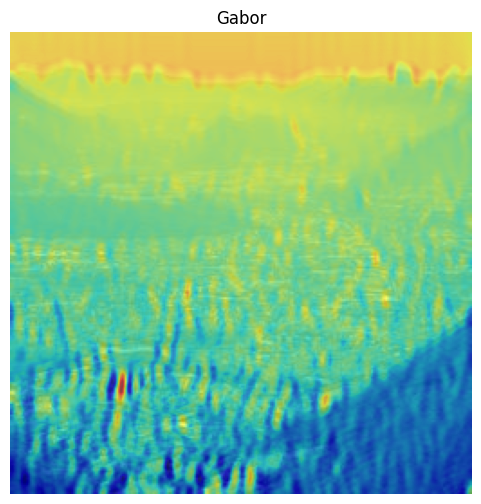

In [17]:
def extract_features(img, srm_filters, gabor_kerns):
    residual_maps = [cv2.filter2D(img.astype(np.float32), -1, f) for f in srm_filters]
    gabor_maps = [cv2.filter2D(img, cv2.CV_32F, k) for k in gabor_kerns]
    return np.stack(residual_maps, axis=-1), np.stack(gabor_maps, axis=-1)


def overlay_heatmap(original, feature_map, title="", alpha=0.6, cmap="jet"):
    """
    Overlay a feature map (residual or gabor) on top of the original image.
    """
    # Normalize feature map to [0, 1]
    norm_map = cv2.normalize(feature_map, None, 0, 1, cv2.NORM_MINMAX)

    plt.figure(figsize=(6,6))
    plt.imshow(original, cmap="gray")
    plt.imshow(norm_map, cmap=cmap, alpha=alpha)
    plt.title(title)
    plt.axis("off")
    plt.show()


residual_maps, gabor_maps = extract_features(img, srm_filters, gabor_kerns)
overlay_heatmap(img, residual_maps[..., 0], title="SRM residual")
overlay_heatmap(img, gabor_maps[..., 0], title="Gabor")

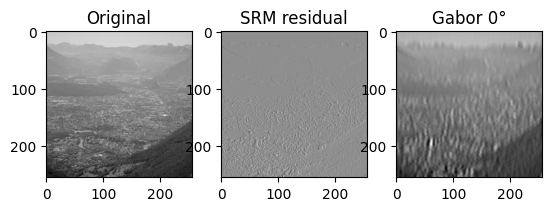

In [18]:
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title("Original")

# visualize one SRM residual
plt.subplot(1, 3, 2)
plt.imshow(residual_maps[..., 0], cmap='gray')
plt.title("SRM residual")

# visualize one Gabor map
plt.subplot(1, 3, 3)
plt.imshow(gabor_maps[..., 0], cmap='gray')
plt.title("Gabor 0°")
plt.show()


Testing CoverReconstructionGenerator...
Input shapes:
  Stego image: torch.Size([4, 1, 256, 256])
  Residual features: torch.Size([4, 7, 256, 256])
  Concatenated input: torch.Size([4, 8, 256, 256])
Reconstructed cover shape: torch.Size([4, 1, 256, 256])
Reconstructed cover range: [0.165, 0.676]
Initial MSE loss (reconstructed vs stego): 0.245743


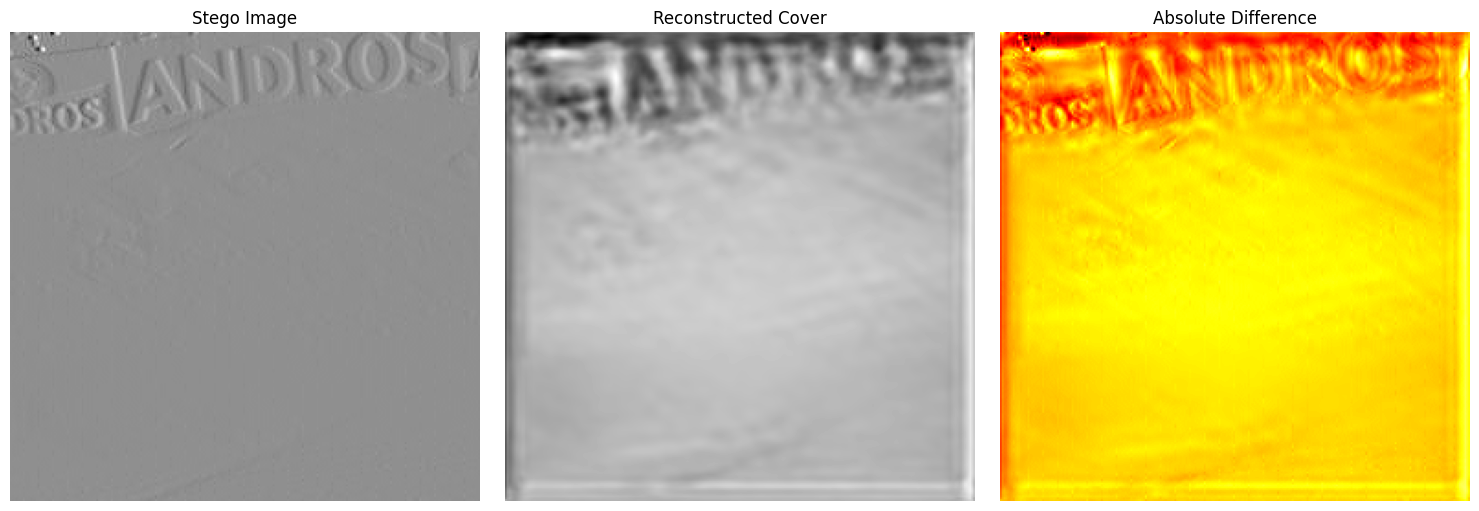

Difference stats - Min: 0.0058, Max: 0.7451, Mean: 0.5060


In [19]:
class CoverReconstructionGenerator(nn.Module):
    """Generator that reconstructs cover images from stego + residual features"""
    def __init__(self, input_channels=8, base_ch=32, latent_ch=128):
        super().__init__()
        
        # Encoder: Process stego + residuals to latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, base_ch, 3, padding=1, bias=False),  # input: stego + residuals
            nn.GroupNorm(min(8, base_ch), base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, base_ch*2, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*2), base_ch*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch*2, base_ch*4, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*4), base_ch*4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(base_ch*4, latent_ch, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, latent_ch), latent_ch),
            nn.ReLU(inplace=True)
        )
        
        # Decoder: Reconstruct cover from latent representation
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_ch, base_ch*4, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*4), base_ch*4),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_ch*4, base_ch*2, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch*2), base_ch*2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(base_ch*2, base_ch, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch), base_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_ch, 1, 3, padding=1, bias=False),  # output single channel
            nn.Sigmoid()  # output in [0,1] range
        )
        
    def forward(self, stego_img, residual_features):
        """
        Args:
            stego_img: (B, 1, H, W) - stego image
            residual_features: (B, C, H, W) - features from RAN
        Returns:
            reconstructed_cover: (B, 1, H, W)
        """
        # Concatenate stego with residual features along channel dimension
        x = torch.cat([stego_img, residual_features], dim=1)
        
        # Encode to latent space
        latent = self.encoder(x)
        
        # Decode to reconstruct cover
        reconstructed_cover = self.decoder(latent)
        
        return reconstructed_cover

# Test the Generator again
def test_generator():
    print("Testing CoverReconstructionGenerator...")
    
    # Create generator instance with correct input channels
    input_channels = 8  # 1 (stego) + 7 (residuals)
    generator = CoverReconstructionGenerator(input_channels=input_channels, base_ch=32, latent_ch=128)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch  # fused_input: (B, C, H, W)
        
        # Extract stego image (first channel) and residual features (remaining channels)
        stego_img = fused_input[:, 0:1, :, :]  # (B, 1, H, W) - grayscale image
        residual_features = fused_input[:, 1:, :, :]  # (B, 7, H, W) - residual features
        
        print(f"Input shapes:")
        print(f"  Stego image: {stego_img.shape}")
        print(f"  Residual features: {residual_features.shape}")
        print(f"  Concatenated input: {torch.cat([stego_img, residual_features], dim=1).shape}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        generator = generator.to(device)
        stego_img = stego_img.to(device)
        residual_features = residual_features.to(device)
        
        # Forward pass through generator
        with torch.no_grad():
            reconstructed_cover = generator(stego_img, residual_features)
        
        print(f"Reconstructed cover shape: {reconstructed_cover.shape}")
        print(f"Reconstructed cover range: [{reconstructed_cover.min().item():.3f}, {reconstructed_cover.max().item():.3f}]")
        
        # Test reconstruction loss
        mse_loss = F.mse_loss(reconstructed_cover, stego_img)
        print(f"Initial MSE loss (reconstructed vs stego): {mse_loss.item():.6f}")
        
        # Visualize one example
        visualize_reconstruction(stego_img[0], reconstructed_cover[0])
        
        break

def visualize_reconstruction(stego, reconstructed):
    """Visualize stego and reconstructed images"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert tensors to numpy for visualization
    stego_np = stego.squeeze().cpu().numpy()
    reconstructed_np = reconstructed.squeeze().cpu().numpy()
    
    # Original stego
    axes[0].imshow(stego_np, cmap='gray')
    axes[0].set_title('Stego Image')
    axes[0].axis('off')
    
    # Reconstructed cover
    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title('Reconstructed Cover')
    axes[1].axis('off')
    
    # Difference
    diff = np.abs(stego_np - reconstructed_np)
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Difference stats - Min: {diff.min():.4f}, Max: {diff.max():.4f}, Mean: {diff.mean():.4f}")

# Run the test again
test_generator()

Testing CoverReconstructionGenerator...
Input shapes:
  Stego image: torch.Size([4, 1, 256, 256])
  Residual features: torch.Size([4, 7, 256, 256])
Reconstructed cover shape: torch.Size([4, 1, 256, 256])
Reconstructed cover range: [0.083, 0.601]
Initial MSE loss (reconstructed vs stego): 0.162708


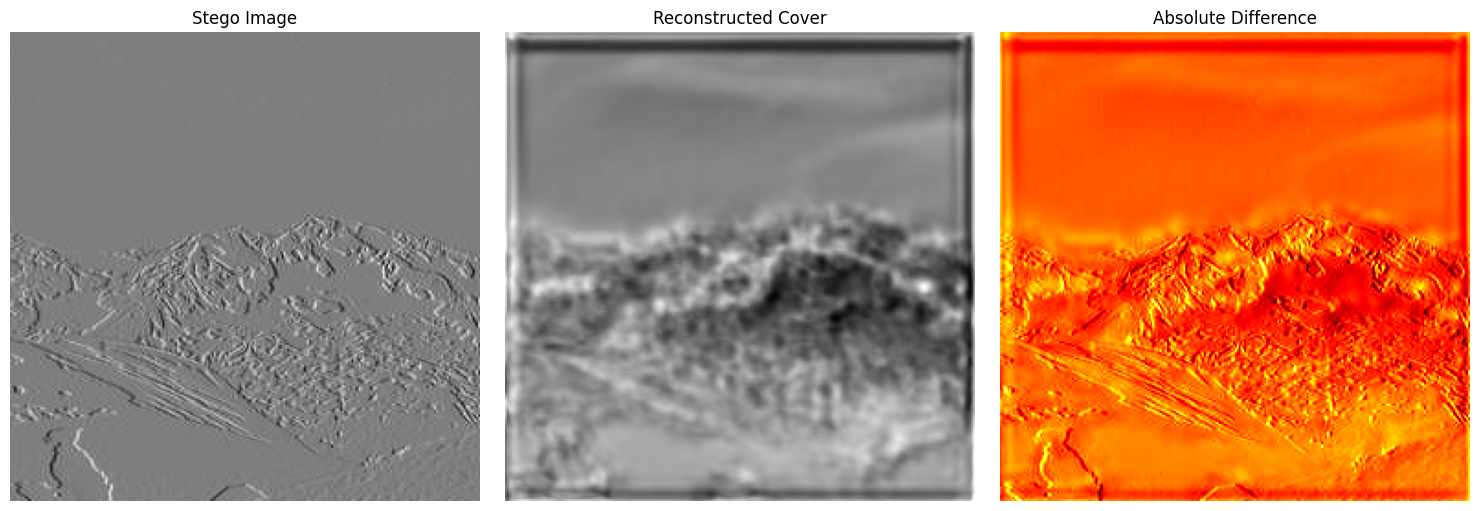

Difference stats - Min: 0.0020, Max: 0.7625, Mean: 0.3797


In [20]:
# Test the Generator
def test_generator():
    print("Testing CoverReconstructionGenerator...")
    
    # Create generator instance
    generator = CoverReconstructionGenerator(base_ch=32, latent_ch=128)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch  # fused_input: (B, C, H, W)
        
        # Extract stego image (first channel) and residual features (remaining channels)
        stego_img = fused_input[:, 0:1, :, :]  # (B, 1, H, W) - grayscale image
        residual_features = fused_input[:, 1:, :, :]  # (B, C-1, H, W) - residual features
        
        print(f"Input shapes:")
        print(f"  Stego image: {stego_img.shape}")
        print(f"  Residual features: {residual_features.shape}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        generator = generator.to(device)
        stego_img = stego_img.to(device)
        residual_features = residual_features.to(device)
        
        # Forward pass through generator
        with torch.no_grad():
            reconstructed_cover = generator(stego_img, residual_features)
        
        print(f"Reconstructed cover shape: {reconstructed_cover.shape}")
        print(f"Reconstructed cover range: [{reconstructed_cover.min().item():.3f}, {reconstructed_cover.max().item():.3f}]")
        
        # Test reconstruction loss
        mse_loss = F.mse_loss(reconstructed_cover, stego_img)
        print(f"Initial MSE loss (reconstructed vs stego): {mse_loss.item():.6f}")
        
        # Visualize one example
        visualize_reconstruction(stego_img[0], reconstructed_cover[0])
        
        break

def visualize_reconstruction(stego, reconstructed):
    """Visualize stego and reconstructed images"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert tensors to numpy for visualization
    stego_np = stego.squeeze().cpu().numpy()
    reconstructed_np = reconstructed.squeeze().cpu().numpy()
    
    # Original stego
    axes[0].imshow(stego_np, cmap='gray')
    axes[0].set_title('Stego Image')
    axes[0].axis('off')
    
    # Reconstructed cover
    axes[1].imshow(reconstructed_np, cmap='gray')
    axes[1].set_title('Reconstructed Cover')
    axes[1].axis('off')
    
    # Difference
    diff = np.abs(stego_np - reconstructed_np)
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title('Absolute Difference')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Difference stats - Min: {diff.min():.4f}, Max: {diff.max():.4f}, Mean: {diff.mean():.4f}")

# Run the test
test_generator()

In [21]:
class SteganalysisClassifier(nn.Module):
    """Classifier that detects stego vs cover using RAN features"""
    def __init__(self, input_channels, base_ch=32, num_classes=2):
        super().__init__()
        
        # Feature processing backbone (similar to your RAN but for classification)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(input_channels, base_ch, 3, padding=1, bias=False),
            nn.GroupNorm(min(8, base_ch), base_ch),
            nn.ReLU(inplace=True),
            ResidualAttentionBlock(base_ch, reduction=8),
            ConvBlockPool(base_ch, base_ch*2),
            ResidualAttentionBlock(base_ch*2, reduction=8),
            ConvBlockGlobalPool(base_ch*2, reduction=8),
            nn.Conv2d(base_ch*2, base_ch*4, 1, bias=False),
            nn.GroupNorm(min(8, base_ch*4), base_ch*4),
            nn.ReLU(inplace=True),
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(base_ch*4, base_ch*2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(base_ch*2, num_classes)
        )
        
    def forward(self, x):
        """
        Args:
            x: (B, C, H, W) - fused input (image + residuals)
        Returns:
            logits: (B, num_classes) - classification logits
        """
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

In [22]:
# Test the Steganalysis Classifier
def test_classifier():
    print("Testing SteganalysisClassifier...")
    
    # Create classifier instance
    input_channels = 8  # Same as generator input
    classifier = SteganalysisClassifier(input_channels=input_channels, base_ch=32, num_classes=2)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch  # fused_input: (B, 8, H, W), labels: (B,)
        
        print(f"Input shapes:")
        print(f"  Fused input: {fused_input.shape}")
        print(f"  Labels: {labels.shape}")
        print(f"  Labels: {labels}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        classifier = classifier.to(device)
        fused_input = fused_input.to(device)
        labels = labels.to(device)
        
        # Forward pass through classifier
        with torch.no_grad():
            logits = classifier(fused_input)
        
        print(f"Classifier output shapes:")
        print(f"  Logits: {logits.shape}")
        print(f"  Logits values: {logits}")
        
        # Convert logits to probabilities and predictions
        probabilities = F.softmax(logits, dim=1)
        predictions = torch.argmax(logits, dim=1)
        
        print(f"Probabilities: {probabilities}")
        print(f"Predictions: {predictions}")
        print(f"Ground truth: {labels}")
        
        # Calculate initial accuracy
        correct = (predictions == labels).sum().item()
        accuracy = correct / len(labels)
        print(f"Initial accuracy: {accuracy:.4f} ({correct}/{len(labels)})")
        
        # Test classification loss
        classification_loss = F.cross_entropy(logits, labels.long())
        print(f"Initial classification loss: {classification_loss.item():.6f}")
        
        break

# Run the classifier test
test_classifier()

Testing SteganalysisClassifier...
Input shapes:
  Fused input: torch.Size([4, 8, 256, 256])
  Labels: torch.Size([4])
  Labels: tensor([0., 0., 1., 1.])
Classifier output shapes:
  Logits: torch.Size([4, 2])
  Logits values: tensor([[ 0.5482, -0.0630],
        [ 0.6789, -0.1389],
        [ 0.3905, -0.1737],
        [ 0.4840, -0.0872]], device='cuda:0')
Probabilities: tensor([[0.6482, 0.3518],
        [0.6938, 0.3062],
        [0.6374, 0.3626],
        [0.6390, 0.3610]], device='cuda:0')
Predictions: tensor([0, 0, 0, 0], device='cuda:0')
Ground truth: tensor([0., 0., 1., 1.], device='cuda:0')
Initial accuracy: 0.5000 (2/4)
Initial classification loss: 0.708172


In [23]:
class DualAdversarialNetwork(nn.Module):
    """Main DAN that combines classifier and generator with adversarial training"""
    def __init__(self, input_channels=8, base_ch=32, latent_ch=128, num_classes=2):
        super().__init__()
        
        # Shared feature extractor (your RAN)
        self.feature_extractor = ResidualAttentionNet(c_in=input_channels, base_ch=base_ch)
        
        # Branch 1: Steganalysis Classifier
        self.classifier = SteganalysisClassifier(input_channels, base_ch, num_classes)
        
        # Branch 2: Cover Reconstruction Generator  
        self.generator = CoverReconstructionGenerator(input_channels, base_ch, latent_ch)
        
        # Dynamic attention mechanism (we'll enhance this later)
        self.attention_weights = None
        
    def forward(self, x, use_generator=False):
        """
        Args:
            x: (B, C, H, W) - fused input
            use_generator: whether to use generator branch
        Returns:
            dict with classification and reconstruction outputs
        """
        # Extract features using RAN
        features = self.feature_extractor(x)
        
        # Get stego image (first channel) for generator
        stego_img = x[:, 0:1, :, :]  # (B, 1, H, W)
        residual_features = x[:, 1:, :, :]  # (B, 7, H, W)
        
        # Branch 1: Classification
        classification_logits = self.classifier(x)
        
        # Branch 2: Reconstruction (optional)
        reconstructed_cover = None
        if use_generator:
            reconstructed_cover = self.generator(stego_img, residual_features)
        
        return {
            'classification_logits': classification_logits,
            'reconstructed_cover': reconstructed_cover,
            'features': features
        }

In [24]:
# Test the complete Dual-Adversarial Network
def test_dan():
    print("Testing DualAdversarialNetwork...")
    
    # Create DAN instance
    dan = DualAdversarialNetwork(input_channels=8, base_ch=32)
    
    # Get a batch from your dataloader
    for batch in dataloader:
        fused_input, labels = batch
        
        print(f"Input shape: {fused_input.shape}")
        print(f"Labels: {labels}")
        
        # Move to device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dan = dan.to(device)
        fused_input = fused_input.to(device)
        labels = labels.to(device)
        
        # Test with generator
        print("\n--- Testing with Generator ---")
        with torch.no_grad():
            outputs = dan(fused_input, use_generator=True)
        
        print(f"Classification logits shape: {outputs['classification_logits'].shape}")
        print(f"Reconstructed cover shape: {outputs['reconstructed_cover'].shape}")
        print(f"Features shape: {outputs['features'].shape}")
        
        # Test without generator
        print("\n--- Testing without Generator ---")
        with torch.no_grad():
            outputs_no_gen = dan(fused_input, use_generator=False)
        
        print(f"Classification logits shape: {outputs_no_gen['classification_logits'].shape}")
        print(f"Reconstructed cover: {outputs_no_gen['reconstructed_cover']}")
        
        break

# Run the DAN test
test_dan()

Testing DualAdversarialNetwork...
Input shape: torch.Size([4, 8, 256, 256])
Labels: tensor([0., 0., 0., 0.])

--- Testing with Generator ---
Classification logits shape: torch.Size([4, 2])
Reconstructed cover shape: torch.Size([4, 1, 256, 256])
Features shape: torch.Size([4, 128, 128, 128])

--- Testing without Generator ---
Classification logits shape: torch.Size([4, 2])
Reconstructed cover: None


In [25]:
class DANLoss(nn.Module):
    """Combined loss for Dual-Adversarial Network"""
    def __init__(self, alpha=1.0, beta=0.5):
        super().__init__()
        self.alpha = alpha  # Classification loss weight
        self.beta = beta    # Reconstruction loss weight
        self.classification_loss = nn.CrossEntropyLoss()
        self.reconstruction_loss = nn.MSELoss()
        
    def forward(self, outputs, labels, stego_images=None, cover_images=None):
        """
        Args:
            outputs: dict from DAN forward pass
            labels: ground truth labels
            stego_images: input stego images (for reconstruction loss)
            cover_images: ground truth cover images (for reconstruction loss)
        """
        total_loss = 0.0
        loss_dict = {}
        
        # Classification loss
        class_loss = self.classification_loss(outputs['classification_logits'], labels.long())
        total_loss += self.alpha * class_loss
        loss_dict['classification_loss'] = class_loss.item()
        
        # Reconstruction loss (only if generator was used)
        if outputs['reconstructed_cover'] is not None and stego_images is not None and cover_images is not None:
            # For stego images, try to reconstruct the original cover
            # For cover images, reconstruction should match input
            target_images = cover_images if cover_images is not None else stego_images
            recon_loss = self.reconstruction_loss(outputs['reconstructed_cover'], target_images)
            total_loss += self.beta * recon_loss
            loss_dict['reconstruction_loss'] = recon_loss.item()
        
        loss_dict['total_loss'] = total_loss.item()
        return total_loss, loss_dict

def test_dan_training():
    """Test a single training step with the DAN"""
    print("Testing DAN Training Step...")
    
    # Create DAN and loss
    dan = DualAdversarialNetwork(input_channels=8, base_ch=32)
    criterion = DANLoss(alpha=1.0, beta=0.5)
    
    # Get a batch
    for batch in dataloader:
        fused_input, labels = batch
        
        # For reconstruction loss, we need the original images
        # In real training, you'd have separate cover images
        stego_images = fused_input[:, 0:1, :, :]  # Use stego channel as proxy
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dan = dan.to(device)
        fused_input = fused_input.to(device)
        labels = labels.to(device)
        stego_images = stego_images.to(device)
        
        # Forward pass with generator
        outputs = dan(fused_input, use_generator=True)
        
        # Calculate loss
        total_loss, loss_dict = criterion(outputs, labels, stego_images, stego_images)
        
        print("Loss breakdown:")
        for loss_name, loss_value in loss_dict.items():
            print(f"  {loss_name}: {loss_value:.6f}")
        
        # Simulate backward pass
        print("\nSimulating backward pass...")
        
        # In real training:
        # total_loss.backward()
        # optimizer.step()
        
        print("Training step completed successfully!")
        break

# Test the training setup
test_dan_training()

Testing DAN Training Step...
Loss breakdown:
  classification_loss: 0.868960
  reconstruction_loss: 0.349175
  total_loss: 1.043547

Simulating backward pass...
Training step completed successfully!


In [26]:
class DANTrainer:
    """Trainer for the Dual-Adversarial Network"""
    def __init__(self, model, train_loader, val_loader=None, device='cuda'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Move model to device
        self.model = self.model.to(self.device)
        
        # Optimizer
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=1e-4, 
            weight_decay=1e-4
        )
        
        # Loss function
        self.criterion = DANLoss(alpha=1.0, beta=0.5)
        
        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (fused_input, labels) in enumerate(self.train_loader):
            # Move to device
            fused_input = fused_input.to(self.device)
            labels = labels.to(self.device)
            stego_images = fused_input[:, 0:1, :, :]  # Extract stego channel
            
            # Zero gradients
            self.optimizer.zero_grad()
            
            # Forward pass with generator
            outputs = self.model(fused_input, use_generator=True)
            
            # Calculate loss
            loss, loss_dict = self.criterion(outputs, labels, stego_images, stego_images)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Track metrics
            total_loss += loss_dict['total_loss']
            
            # Calculate accuracy
            preds = torch.argmax(outputs['classification_logits'], dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} | Batch: {batch_idx}/{len(self.train_loader)} | '
                      f'Loss: {loss_dict["total_loss"]:.4f} | '
                      f'Class: {loss_dict["classification_loss"]:.4f} | '
                      f'Recon: {loss_dict.get("reconstruction_loss", 0):.4f}')
        
        epoch_loss = total_loss / len(self.train_loader)
        epoch_accuracy = correct / total
        
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_accuracy)
        
        return epoch_loss, epoch_accuracy
    
    def validate(self, epoch):
        """Validate the model"""
        if self.val_loader is None:
            return None, None
            
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for fused_input, labels in self.val_loader:
                fused_input = fused_input.to(self.device)
                labels = labels.to(self.device)
                stego_images = fused_input[:, 0:1, :, :]
                
                # Forward pass (generator optional during validation)
                outputs = self.model(fused_input, use_generator=False)
                
                # Calculate loss (only classification during validation)
                loss, loss_dict = self.criterion(outputs, labels)
                
                total_loss += loss_dict['total_loss']
                
                # Calculate accuracy
                preds = torch.argmax(outputs['classification_logits'], dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        epoch_loss = total_loss / len(self.val_loader)
        epoch_accuracy = correct / total
        
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_accuracy)
        
        print(f'Validation | Epoch: {epoch} | Loss: {epoch_loss:.4f} | Acc: {epoch_accuracy:.4f}')
        
        return epoch_loss, epoch_accuracy
    
    def train(self, num_epochs=10):
        """Full training loop"""
        print("Starting DAN Training...")
        
        for epoch in range(1, num_epochs + 1):
            # Train
            train_loss, train_acc = self.train_epoch(epoch)
            print(f'Epoch {epoch} Summary:')
            print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
            
            # Validate
            if self.val_loader is not None:
                val_loss, val_acc = self.validate(epoch)
                print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            
            print('-' * 50)

# Test the training setup with a single epoch
def test_training_loop():
    """Test one epoch of training"""
    print("Testing Training Loop...")
    
    # Create DAN
    dan = DualAdversarialNetwork(input_channels=8, base_ch=32)
    
    # Create trainer (model will be moved to device in trainer init)
    trainer = DANTrainer(dan, dataloader, device='cuda')
    
    # Train for one epoch
    print("Training one epoch...")
    trainer.train(num_epochs=1)
    
    print("Training test completed successfully!")

# Run the training test
test_training_loop()

Testing Training Loop...
Training one epoch...
Starting DAN Training...
Epoch: 1 | Batch: 0/4500 | Loss: 0.8012 | Class: 0.7087 | Recon: 0.1850
Epoch: 1 | Batch: 10/4500 | Loss: 0.6268 | Class: 0.6059 | Recon: 0.0418
Epoch: 1 | Batch: 20/4500 | Loss: 0.7150 | Class: 0.6982 | Recon: 0.0336
Epoch: 1 | Batch: 30/4500 | Loss: 0.7199 | Class: 0.7078 | Recon: 0.0242
Epoch: 1 | Batch: 40/4500 | Loss: 0.7686 | Class: 0.7581 | Recon: 0.0209
Epoch: 1 | Batch: 50/4500 | Loss: 0.6907 | Class: 0.6818 | Recon: 0.0177
Epoch: 1 | Batch: 60/4500 | Loss: 0.7155 | Class: 0.7069 | Recon: 0.0170
Epoch: 1 | Batch: 70/4500 | Loss: 0.6563 | Class: 0.6495 | Recon: 0.0136
Epoch: 1 | Batch: 80/4500 | Loss: 0.7419 | Class: 0.7342 | Recon: 0.0155
Epoch: 1 | Batch: 90/4500 | Loss: 0.7127 | Class: 0.7072 | Recon: 0.0109
Epoch: 1 | Batch: 100/4500 | Loss: 0.6957 | Class: 0.6909 | Recon: 0.0096
Epoch: 1 | Batch: 110/4500 | Loss: 0.6340 | Class: 0.6273 | Recon: 0.0134
Epoch: 1 | Batch: 120/4500 | Loss: 0.7409 | Class: 

In [29]:
class TrueDualAdversarialNetwork(nn.Module):
    """Proper DAN that uses RAN features and has true adversarial training"""
    def __init__(self, input_channels=8, base_ch=32, latent_ch=128, num_classes=2):
        super().__init__()
        
        # Your original RAN as shared feature extractor
        self.ran_feature_extractor = ResidualAttentionNet(c_in=input_channels, base_ch=base_ch)
        
        # Branch 1: Classifier that uses RAN features
        self.classifier = nn.Sequential(
            nn.Conv2d(128, base_ch*2, 3, padding=1, bias=False),  # Input from RAN features (128 channels)
            nn.GroupNorm(min(8, base_ch*2), base_ch*2),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_ch*2, num_classes)
        )
        
        # Branch 2: Generator that uses both stego and RAN features
        self.generator = CoverReconstructionGenerator(
            input_channels=1 + 128,  # stego_img + RAN_features
            base_ch=base_ch, 
            latent_ch=latent_ch
        )
        
    def forward(self, x, use_generator=False):
        """
        Proper integration: RAN features → both branches
        """
        # Extract features using your RAN
        ran_features = self.ran_feature_extractor(x)  # (B, 128, H/4, W/4)
        
        # Get stego image
        stego_img = x[:, 0:1, :, :]  # (B, 1, H, W)
        
        # Branch 1: Classification using RAN features
        classification_logits = self.classifier(ran_features)
        
        # Branch 2: Reconstruction using stego + RAN features
        reconstructed_cover = None
        if use_generator:
            # Upsample RAN features to match stego image size
            ran_features_upsampled = F.interpolate(
                ran_features, size=stego_img.shape[2:], mode='bilinear', align_corners=False
            )
            reconstructed_cover = self.generator(stego_img, ran_features_upsampled)
        
        return {
            'classification_logits': classification_logits,
            'reconstructed_cover': reconstructed_cover,
            'ran_features': ran_features
        }

class AdversarialDANLoss(nn.Module):
    """True adversarial loss with gradient reversal"""
    def __init__(self, alpha=1.0, beta=0.5, gamma=0.1):
        super().__init__()
        self.alpha = alpha  # Classification loss weight
        self.beta = beta    # Reconstruction loss weight  
        self.gamma = gamma  # Adversarial loss weight
        
    def forward(self, outputs, labels, stego_images, cover_images=None, epoch=None):
        total_loss = 0.0
        loss_dict = {}
        
        # 1. Classification loss
        class_loss = F.cross_entropy(outputs['classification_logits'], labels.long())
        total_loss += self.alpha * class_loss
        loss_dict['classification_loss'] = class_loss.item()
        
        # 2. Reconstruction loss
        if outputs['reconstructed_cover'] is not None:
            target = cover_images if cover_images is not None else stego_images
            recon_loss = F.mse_loss(outputs['reconstructed_cover'], target)
            total_loss += self.beta * recon_loss
            loss_dict['reconstruction_loss'] = recon_loss.item()
            
            # 3. Adversarial loss: Generator tries to fool classifier
            # When generator is good, reconstructed "cover" should be classified as cover (label 0)
            adv_labels = torch.zeros_like(labels)  # All should be classified as cover
            adv_loss = F.cross_entropy(outputs['classification_logits'], adv_labels.long())
            total_loss -= self.gamma * adv_loss  # Negative for adversarial
            loss_dict['adversarial_loss'] = adv_loss.item()
        
        loss_dict['total_loss'] = total_loss.item()
        return total_loss, loss_dict

# Test the true adversarial DAN with proper device handling
def test_true_adversarial_dan():
    print("=== TESTING TRUE ADVERSARIAL DAN ===")
    
    # Create true adversarial DAN
    true_dan = TrueDualAdversarialNetwork(input_channels=8, base_ch=32)
    
    # Move model to device FIRST
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    true_dan = true_dan.to(device)
    print(f"Model moved to: {device}")
    
    # Test forward pass
    for batch in dataloader:
        fused_input, labels = batch
        fused_input = fused_input.to(device)
        labels = labels.to(device)
        
        print(f"Input shape: {fused_input.shape}")
        
        # Test RAN feature extraction first
        with torch.no_grad():
            ran_features = true_dan.ran_feature_extractor(fused_input)
            print(f"RAN features shape: {ran_features.shape}")
            
            # Test full forward pass
            outputs = true_dan(fused_input, use_generator=True)
            
            print("True Adversarial DAN Outputs:")
            print(f"  Classification logits: {outputs['classification_logits'].shape}")
            print(f"  Reconstructed cover: {outputs['reconstructed_cover'].shape}")
            print(f"  RAN features: {outputs['ran_features'].shape}")
            
            # Test adversarial loss
            criterion = AdversarialDANLoss()
            stego_images = fused_input[:, 0:1, :, :]
            loss, loss_dict = criterion(outputs, labels, stego_images, stego_images)
            
            print("Adversarial Loss Components:")
            for k, v in loss_dict.items():
                print(f"  {k}: {v:.4f}")
        break

# Let's also verify the RAN output dimensions
def verify_ran_dimensions():
    print("\n=== VERIFYING RAN DIMENSIONS ===")
    
    # Test RAN alone
    ran = ResidualAttentionNet(c_in=8, base_ch=32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ran = ran.to(device)
    
    for batch in dataloader:
        fused_input, labels = batch
        fused_input = fused_input.to(device)
        
        print(f"RAN input shape: {fused_input.shape}")
        
        with torch.no_grad():
            features = ran(fused_input)
            print(f"RAN output features shape: {features.shape}")
            print(f"Expected input channels for classifier: {features.shape[1]}")
        break

# Run both tests
verify_ran_dimensions()
test_true_adversarial_dan()


=== VERIFYING RAN DIMENSIONS ===
RAN input shape: torch.Size([4, 8, 256, 256])
RAN output features shape: torch.Size([4, 128, 128, 128])
Expected input channels for classifier: 128
=== TESTING TRUE ADVERSARIAL DAN ===
Model moved to: cuda
Input shape: torch.Size([4, 8, 256, 256])
RAN features shape: torch.Size([4, 128, 128, 128])
True Adversarial DAN Outputs:
  Classification logits: torch.Size([4, 2])
  Reconstructed cover: torch.Size([4, 1, 256, 256])
  RAN features: torch.Size([4, 128, 128, 128])
Adversarial Loss Components:
  classification_loss: 0.6191
  reconstruction_loss: 0.1296
  adversarial_loss: 0.4852
  total_loss: 0.6353


=== STARTING TRUE ADVERSARIAL TRAINING ===
Starting TRUE ADVERSARIAL TRAINING...
Game: Generator vs Classifier with RAN as shared feature extractor

EPOCH 1/2
Epoch: 1 | Batch: 0/4500
  Class Loss: 0.8885 | Recon Loss: 0.2956 | Adv Loss: 0.6068
  Batch Acc: 0.2500
Epoch: 1 | Batch: 100/4500
  Class Loss: 0.7070 | Recon Loss: 0.0140 | Adv Loss: 0.9093
  Batch Acc: 0.5000
Epoch: 1 | Batch: 200/4500
  Class Loss: 0.6809 | Recon Loss: 0.0088 | Adv Loss: 0.6956
  Batch Acc: 0.5000
Epoch: 1 | Batch: 300/4500
  Class Loss: 0.6957 | Recon Loss: 0.0048 | Adv Loss: 0.6252
  Batch Acc: 0.5000
Epoch: 1 | Batch: 400/4500
  Class Loss: 0.7503 | Recon Loss: 0.0027 | Adv Loss: 0.6403
  Batch Acc: 0.0000
Epoch: 1 | Batch: 500/4500
  Class Loss: 0.5988 | Recon Loss: 0.0017 | Adv Loss: 0.5880
  Batch Acc: 1.0000
Epoch: 1 | Batch: 600/4500
  Class Loss: 0.6833 | Recon Loss: 0.0043 | Adv Loss: 0.7891
  Batch Acc: 0.5000
Epoch: 1 | Batch: 700/4500
  Class Loss: 0.7105 | Recon Loss: 0.0040 | Adv Loss: 0.8067

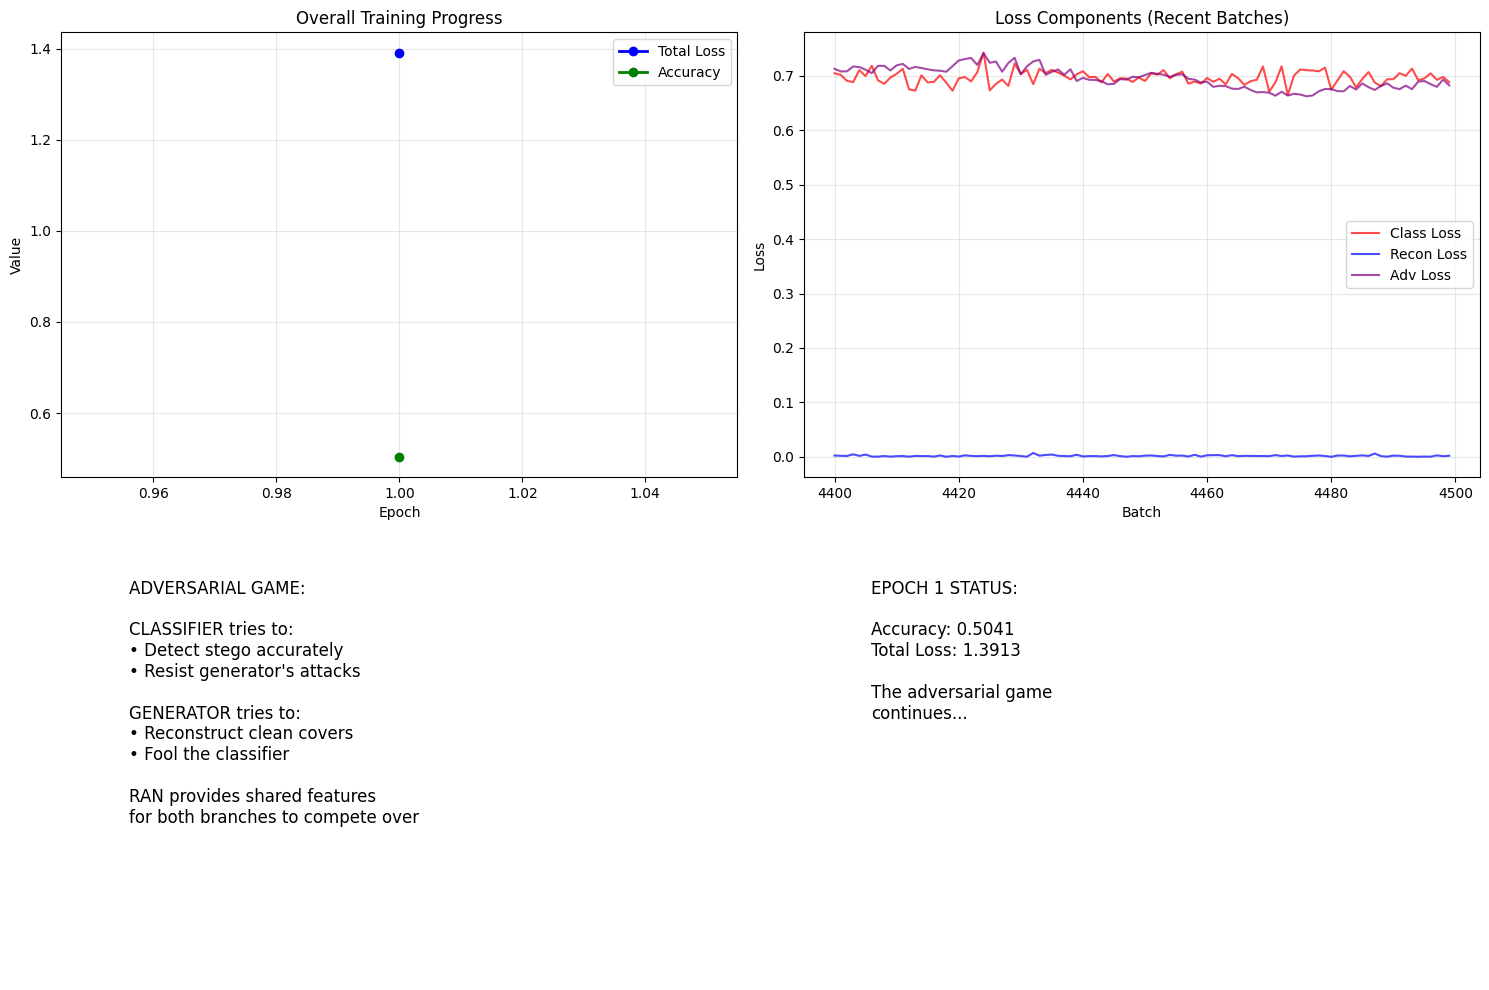


EPOCH 2/2
Epoch: 2 | Batch: 0/4500
  Class Loss: 0.6876 | Recon Loss: 0.0022 | Adv Loss: 0.6867
  Batch Acc: 0.5000
Epoch: 2 | Batch: 100/4500
  Class Loss: 0.6856 | Recon Loss: 0.0013 | Adv Loss: 0.7140
  Batch Acc: 0.7500
Epoch: 2 | Batch: 200/4500
  Class Loss: 0.6902 | Recon Loss: 0.0042 | Adv Loss: 0.7021
  Batch Acc: 0.7500
Epoch: 2 | Batch: 300/4500
  Class Loss: 0.7023 | Recon Loss: 0.0018 | Adv Loss: 0.7057
  Batch Acc: 0.2500
Epoch: 2 | Batch: 400/4500
  Class Loss: 0.7315 | Recon Loss: 0.0026 | Adv Loss: 0.6243
  Batch Acc: 0.2500
Epoch: 2 | Batch: 500/4500
  Class Loss: 0.6989 | Recon Loss: 0.0017 | Adv Loss: 0.6902
  Batch Acc: 0.2500
Epoch: 2 | Batch: 600/4500
  Class Loss: 0.6942 | Recon Loss: 0.0028 | Adv Loss: 0.6584
  Batch Acc: 0.5000
Epoch: 2 | Batch: 700/4500
  Class Loss: 0.7021 | Recon Loss: 0.0014 | Adv Loss: 0.6842
  Batch Acc: 0.2500
Epoch: 2 | Batch: 800/4500
  Class Loss: 0.6916 | Recon Loss: 0.0025 | Adv Loss: 0.7174
  Batch Acc: 0.5000
Epoch: 2 | Batch: 9

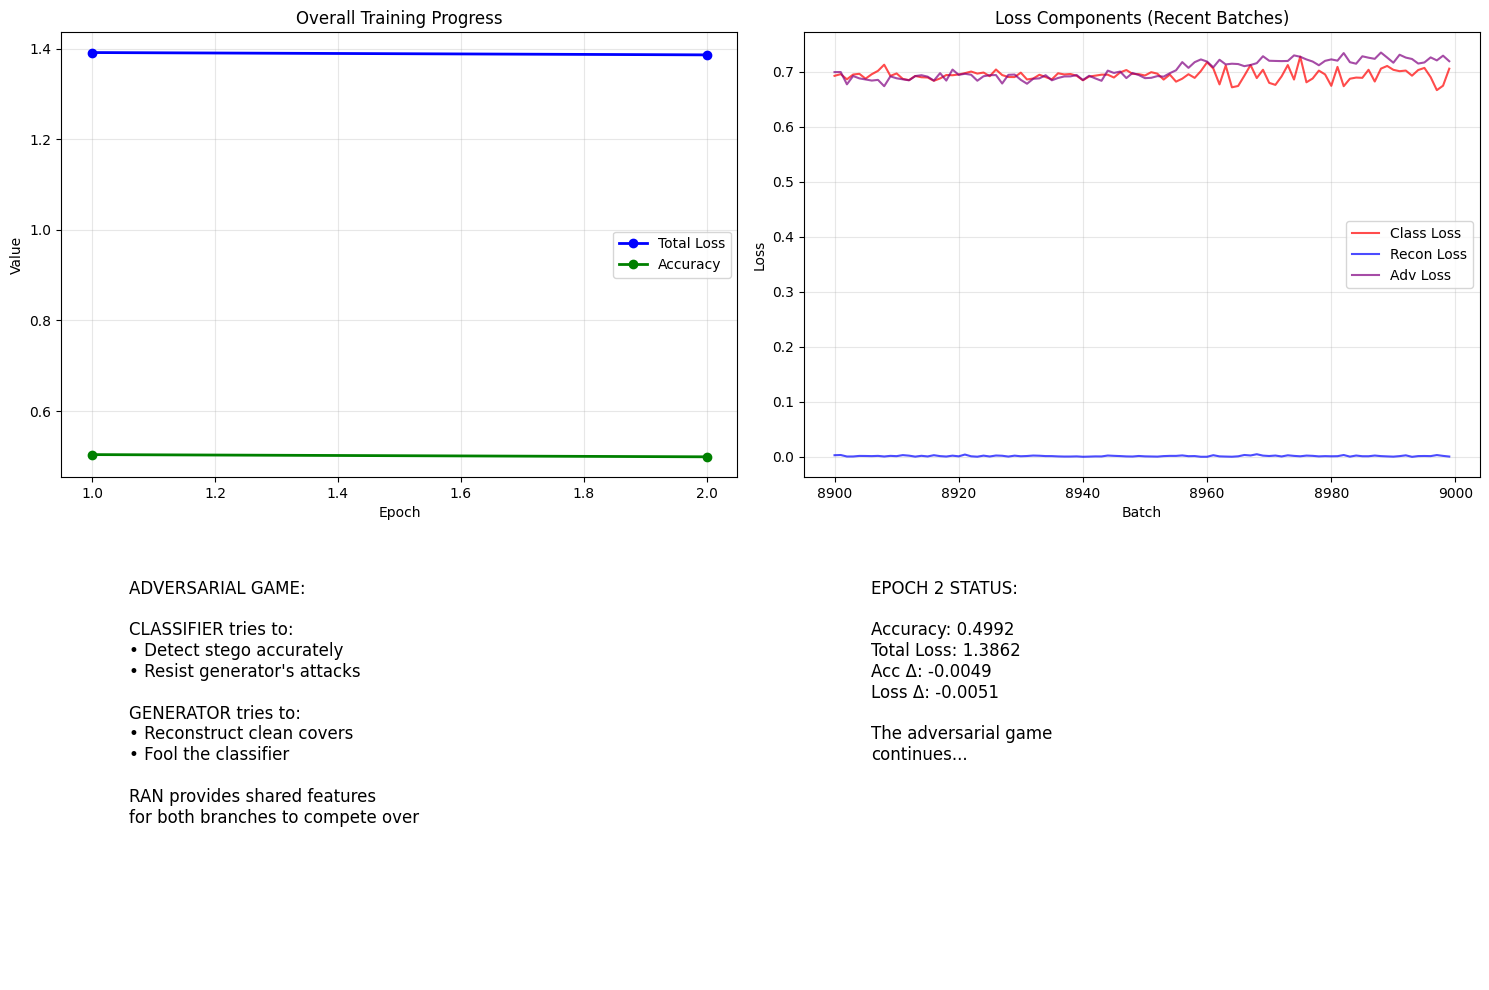

In [31]:
class AdversarialDANTrainer:
    """Trainer for the true adversarial DAN"""
    def __init__(self, model, train_loader, val_loader=None, device='cuda'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        # Move model to device
        self.model = self.model.to(self.device)
        
        # Separate optimizers for different components
        self.optimizer_classifier = torch.optim.AdamW(
            list(self.model.ran_feature_extractor.parameters()) + 
            list(self.model.classifier.parameters()),
            lr=1e-4, weight_decay=1e-4
        )
        
        self.optimizer_generator = torch.optim.AdamW(
            self.model.generator.parameters(),
            lr=1e-4, weight_decay=1e-4
        )
        
        # Adversarial loss
        self.criterion = AdversarialDANLoss(alpha=1.0, beta=0.5, gamma=0.1)
        
        # Tracking
        self.train_losses = []
        self.train_accuracies = []
        self.class_losses = []
        self.recon_losses = []
        self.adv_losses = []
        
    def train_epoch(self, epoch):
        """Train one epoch with adversarial dynamics"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (fused_input, labels) in enumerate(self.train_loader):
            # Move to device
            fused_input = fused_input.to(self.device)
            labels = labels.to(self.device)
            stego_images = fused_input[:, 0:1, :, :]
            
            # ===== TRAIN CLASSIFIER =====
            self.optimizer_classifier.zero_grad()
            self.optimizer_generator.zero_grad()
            
            # Forward pass with generator
            outputs = self.model(fused_input, use_generator=True)
            
            # Calculate CLASSIFIER loss (minimize classification error)
            class_loss = F.cross_entropy(outputs['classification_logits'], labels.long())
            
            # Classifier backward pass
            class_loss.backward(retain_graph=True)
            self.optimizer_classifier.step()
            
            # ===== TRAIN GENERATOR =====
            self.optimizer_classifier.zero_grad()
            self.optimizer_generator.zero_grad()
            
            # Forward pass again (or reuse outputs with new computation graph)
            outputs = self.model(fused_input, use_generator=True)
            
            # Calculate GENERATOR loss (reconstruction + adversarial)
            recon_loss = F.mse_loss(outputs['reconstructed_cover'], stego_images)
            
            # Adversarial: generator wants classifier to think reconstructions are covers (label 0)
            adv_labels = torch.zeros_like(labels)
            adv_loss = F.cross_entropy(outputs['classification_logits'], adv_labels.long())
            
            # Generator total loss: reconstruction + adversarial (negative to fool classifier)
            generator_loss = recon_loss - 0.1 * adv_loss
            
            # Generator backward pass
            generator_loss.backward()
            self.optimizer_generator.step()
            
            # Track metrics
            total_batch_loss = class_loss.item() + recon_loss.item() + adv_loss.item()
            total_loss += total_batch_loss
            
            # Store loss components for visualization
            self.class_losses.append(class_loss.item())
            self.recon_losses.append(recon_loss.item())
            self.adv_losses.append(adv_loss.item())
            
            # Calculate accuracy
            with torch.no_grad():
                preds = torch.argmax(outputs['classification_logits'], dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch} | Batch: {batch_idx}/{len(self.train_loader)}')
                print(f'  Class Loss: {class_loss.item():.4f} | '
                      f'Recon Loss: {recon_loss.item():.4f} | '
                      f'Adv Loss: {adv_loss.item():.4f}')
                print(f'  Batch Acc: {(preds == labels).float().mean().item():.4f}')
        
        # Store epoch metrics
        epoch_loss = total_loss / len(self.train_loader)
        epoch_accuracy = correct / total
        
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_accuracy)
        
        return epoch_loss, epoch_accuracy
    
    def train(self, num_epochs=5):
        """Full adversarial training"""
        print("Starting TRUE ADVERSARIAL TRAINING...")
        print("Game: Generator vs Classifier with RAN as shared feature extractor")
        
        for epoch in range(1, num_epochs + 1):
            print(f"\n{'='*70}")
            print(f"EPOCH {epoch}/{num_epochs}")
            print(f"{'='*70}")
            
            # Train one epoch
            train_loss, train_acc = self.train_epoch(epoch)
            
            print(f"\nEpoch {epoch} Summary:")
            print(f"  Final Train Loss: {train_loss:.4f}")
            print(f"  Final Train Acc: {train_acc:.4f}")
            
            # Visualize adversarial dynamics
            self.visualize_adversarial_progress(epoch)
            
            print(f"{'='*70}")
    
    def visualize_adversarial_progress(self, epoch):
        """Visualize the adversarial game"""
        if len(self.train_losses) < 1:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        epochs = range(1, len(self.train_losses) + 1)
        
        # 1. Overall Training Progress
        axes[0, 0].plot(epochs, self.train_losses, 'b-o', linewidth=2, label='Total Loss')
        axes[0, 0].plot(epochs, self.train_accuracies, 'g-o', linewidth=2, label='Accuracy')
        axes[0, 0].set_title('Overall Training Progress')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Loss Components (last 100 batches of current epoch)
        if len(self.class_losses) > 100:
            recent_batches = range(len(self.class_losses)-100, len(self.class_losses))
            axes[0, 1].plot(recent_batches, self.class_losses[-100:], 'red', alpha=0.7, label='Class Loss')
            axes[0, 1].plot(recent_batches, self.recon_losses[-100:], 'blue', alpha=0.7, label='Recon Loss')
            axes[0, 1].plot(recent_batches, self.adv_losses[-100:], 'purple', alpha=0.7, label='Adv Loss')
            axes[0, 1].set_title('Loss Components (Recent Batches)')
            axes[0, 1].set_xlabel('Batch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Adversarial Dynamics Explanation
        axes[1, 0].axis('off')
        explanation = "ADVERSARIAL GAME:\n\n"
        explanation += "CLASSIFIER tries to:\n"
        explanation += "• Detect stego accurately\n"
        explanation += "• Resist generator's attacks\n\n"
        explanation += "GENERATOR tries to:\n" 
        explanation += "• Reconstruct clean covers\n"
        explanation += "• Fool the classifier\n\n"
        explanation += "RAN provides shared features\nfor both branches to compete over"
        axes[1, 0].text(0.1, 0.9, explanation, transform=axes[1, 0].transAxes, 
                       fontsize=12, verticalalignment='top')
        
        # 4. Current Epoch Status
        axes[1, 1].axis('off')
        status = f"EPOCH {epoch} STATUS:\n\n"
        status += f"Accuracy: {self.train_accuracies[-1]:.4f}\n"
        status += f"Total Loss: {self.train_losses[-1]:.4f}\n"
        if epoch > 1:
            acc_change = self.train_accuracies[-1] - self.train_accuracies[-2]
            loss_change = self.train_losses[-1] - self.train_losses[-2]
            status += f"Acc Δ: {acc_change:+.4f}\n"
            status += f"Loss Δ: {loss_change:+.4f}\n"
        status += f"\nThe adversarial game\ncontinues..."
        axes[1, 1].text(0.1, 0.9, status, transform=axes[1, 1].transAxes,
                       fontsize=12, verticalalignment='top')
        
        plt.tight_layout()
        plt.show()

# Run true adversarial training
def run_adversarial_training():
    print("=== STARTING TRUE ADVERSARIAL TRAINING ===")
    
    # Create true adversarial DAN
    adversarial_dan = TrueDualAdversarialNetwork(input_channels=8, base_ch=32)
    
    # Create adversarial trainer
    trainer = AdversarialDANTrainer(adversarial_dan, dataloader, device='cuda')
    
    # Train for 2 epochs to see adversarial dynamics
    trainer.train(num_epochs=2)
    
    return trainer

# Run the adversarial training
adversarial_trainer = run_adversarial_training()